In [4]:
import pandas as pd
import numpy as np
np.NaN = np.nan # For pandas_ta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr
import pandas_ta as ta

## Gathering Data

### Data Importing

In [5]:
def get_data_frame(fred_code, start_date, end_date):
    df = pdr.get_data_fred(fred_code, start=start_date, end=end_date)
    df = df.reset_index()
    df['Date'] = df['DATE']
    return df

In [6]:
sp_ticker = '^GSPC'
dj_ticker = '^DJI'
nas_ticker = '^IXIC'

cpi_ticker = 'CPIAUCSL'

start_date = '1992-1-1'
end_date = '2025-03-06'

# S&P data
SP500_2000_2025 = yf.download(sp_ticker, start=start_date, end=end_date)

# Dow Jones data
Dow_Jones_Inflation = yf.download(dj_ticker, start=start_date, end=end_date)

# Nasdaq data
Nas_Inflation = yf.download(nas_ticker, start=start_date, end=end_date)

# CPI data
cpi_2000_2025 = pdr.get_data_fred('CPIAUCSL', start=start_date, end=end_date)
cpi_2000_2025 = cpi_2000_2025.reset_index()
cpi_2000_2025['Date'] = cpi_2000_2025['DATE']

# Interest Rates
interest_rates = pdr.get_data_fred('DFF', start=start_date, end=end_date)
interest_rates = interest_rates.reset_index()
interest_rates['Date'] = interest_rates['DATE']

# Unemployment Rates
unempl_rates = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
unempl_rates = unempl_rates.reset_index()
unempl_rates['Date'] = unempl_rates['DATE']

# GDP
gdp = pdr.get_data_fred('GDP', start=start_date, end=end_date)
gdp = gdp.reset_index()
gdp['Date'] = gdp['DATE']

# M2 
M2 = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2 = M2.reset_index()
M2['Date'] = M2['DATE']

# Initial Claims
inital_claims = get_data_frame('ICSA', start_date, end_date)

# Job Openings: Construction
job_openings_construction = get_data_frame('JTS2300JOL', start_date, end_date)

# Job Openings: Private
job_openings_private = get_data_frame('JTS1000JOL', start_date, end_date)

# Job Openings: Non Farm
job_openings_nf = get_data_frame('JTSJOL', start_date, end_date)

# PCE, inflated
PCE = get_data_frame('PCE', start_date, end_date)

# Consumer Debt, inflated
consumer_debt = get_data_frame('REVOLSL', start_date, end_date)

# Percent of paycheck towards debt (includes house debt)
TDSP = get_data_frame('TDSP', start_date, end_date)

# Percent of paycheck towards debt
CDSP = get_data_frame('CDSP', start_date, end_date)

# Short term (2 year) VS Long term (10 year) Bond Interesrt 
T10Y2Y = get_data_frame('T10Y2Y', start_date, end_date)

# Federal Funds VS Long term (10 year) Bond Interesrt 
T10YFF = get_data_frame('T10YFF', start_date, end_date)

# Industrial Production
industrial_prod = get_data_frame('INDPRO', start_date, end_date)

# Capacity Production
capacity_prod = get_data_frame('TCU', start_date, end_date)

# Retail Sales, inflated
retail_sales = get_data_frame('RSAFS', start_date, end_date)

# Personal Savings Rate
personal_savings = get_data_frame('PSAVERT', start_date, end_date)

# 30 Year Fixed Mortgage
mortgage_30_year = get_data_frame('MORTGAGE30US', start_date, end_date)

# New Privately Owned Homes Start
new_priv_housing = get_data_frame('HOUST', start_date, end_date)

# Housing Price Index
house_price_index = get_data_frame('USSTHPI', start_date, end_date)

# Personal Income, inflated
personal_income = get_data_frame('PI', start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Calculating Inflation

### Formula for inflation:

$Adjusted$ $Amount$ = $Past$ $Year$ $Dollar$ $Amount$ $* \frac{Current Year CPI}{Past Year CPI}$

In [7]:
CPI_yearly_amount = cpi_2000_2025.groupby(cpi_2000_2025['Date'].dt.year)['CPIAUCSL'].mean().reset_index()

CPI_2024 = CPI_yearly_amount[CPI_yearly_amount['Date'] == 2025]['CPIAUCSL'].values[0]

def inflation_formula(cpi_curr, past_year, dollar_amount): 
    cpi_past = CPI_yearly_amount[CPI_yearly_amount['Date'] == past_year]['CPIAUCSL'].values[0]
    return dollar_amount * (cpi_curr / cpi_past)
# CPI_yearly_amount = pd.concat([CPI_yearly_amount, pd.DataFrame({'DATE': [2025], 'CPIAUCSL': [CPI_2024]})], ignore_index=True)

In [8]:
def adjust_for_inflation(df):
    df = df.reset_index().copy()
    df_afi = df.assign(
        Close = df.apply(lambda row: inflation_formula(
            CPI_2024,
            row['Date'].dt.year.values[0],
            row['Close']
        ), axis=1),
        High = df.apply(lambda row: inflation_formula(
            CPI_2024,
            row['Date'].dt.year.values[0],
            row['High']
        ), axis=1),
        Low = df.apply(lambda row: inflation_formula(
            CPI_2024,
            row['Date'].dt.year.values[0],
            row['Low']
        ), axis=1),
        Open = df.apply(lambda row: inflation_formula(
            CPI_2024,
            row['Date'].dt.year.values[0],
            row['Open']
        ), axis=1),
    )
    return df_afi

In [9]:
Dow_Jones_data = adjust_for_inflation(Dow_Jones_Inflation)
Nas_data = adjust_for_inflation(Nas_Inflation)
SP500 = adjust_for_inflation(SP500_2000_2025)

In [10]:
PCE_ai = PCE.reset_index().copy()
PCE_ai = PCE.assign(
        PCE = PCE.apply(lambda row: inflation_formula(
            CPI_2024,
            row['Date'].year,
            row['PCE']
        ), axis=1))

consumer_debt_ai = consumer_debt.reset_index().copy()
consumer_debt_ai = consumer_debt.assign(
        REVOLSL = consumer_debt.apply(lambda row: inflation_formula(
            CPI_2024,
            row['Date'].year,
            row['REVOLSL']
        ), axis=1))

retail_sales_ai = retail_sales.reset_index().copy()
retail_sales_ai = retail_sales.assign(
        RSAFS = retail_sales.apply(lambda row: inflation_formula(
            CPI_2024,
            row['Date'].year,
            row['RSAFS']
        ), axis=1))

personal_income_ai = personal_income.assign(
        PI = personal_income.apply(lambda row: inflation_formula(
            CPI_2024,
            row['Date'].year,
            row['PI']
        ), axis=1))

## Defining Function

### Add Data Based on Date

adds a column to a dataset based on the `Date`

returns a new dataframe

In [11]:
def add_data_based_on_date(main_df, new_data, col_name):
    return pd.merge_asof(
            main_df, 
            new_data,
            on='Date',
            direction='backward'
        )[col_name]

### Rate of Change | Percent Change

**Rate of change**

- *Returns*: 

Column based on `previous days`, `column name`.

- *Equation*:

$$\frac{\text{data}_{(\text{days previous})} - \text{data}_{(\text{current day})}}{\text{days previous}}$$


**Rate of change**

- *Returns*: 

Column based on `previous days`, `column name`.

- *Equation*:

$$\frac{\text{data}_{(\text{current day})} - \text{data}_{(\text{days previous})}}{\text{data}_{(\text{days previous})}}$$




In [12]:
def rate_of_change(df, col,days_previous):
    return (df[col].shift(days_previous) - df[col]) / days_previous

def percent_change(df, col,days_previous):
    return round((((df[col] - df[col].shift(days_previous)) / df[col].shift(days_previous)) * 100), 2)

### Plotting Data

**Plots**

- `plot_time_from`

    Plots column based on start year

- `plot_time_frame`

    Plots column based on start year and end year

- `plot_time_frame_x2`

    Plots 2 columns based on start year and end year

In [13]:
def plot_time_from(year, df, x1):
    df_tf = df[df['Date'].dt.year >= year]

    plt.plot(df_tf['Date'], df_tf[x1], label=x1)
    plt.legend()
    plt.show()

def plot_time_frame(year_start, year_end, df, x1):
    df_tf = df[(df['Date'].dt.year >= year_start) & (df['Date'].dt.year <= year_end)]

    plt.plot(df_tf['Date'], df_tf[x1], label=x1)
    plt.legend()
    plt.show()

def plot_time_frames(year_start1, year_end1, year_start2, year_end2, df, x1):
    # Filter for first time frame
    df_tf_1 = df[(df['Date'].dt.year >= year_start1) & (df['Date'].dt.year <= year_end1)]
    
    # Filter for second time frame
    df_tf_2 = df[(df['Date'].dt.year >= year_start2) & (df['Date'].dt.year <= year_end2)]


    days_tf1 = len(df_tf_1)
    days_tf2 = len(df_tf_2)
    
    x_axis1 = np.linspace(0, year_end1 - year_start1, days_tf1)
    x_axis2 = np.linspace(0, year_end2 - year_start2, days_tf2)
    
    # Plot both time frames
    plt.plot(x_axis1, df_tf_1[x1], label=f'{year_start1} - {year_end1}')
    plt.plot(x_axis2, df_tf_2[x1], label=f'{year_start2} - {year_end2}')
    plt.legend()
    plt.show()
def plot_time_frame_x2(year_start, year_end, df, x1, x2):
    df_tf = df[(df['Date'].dt.year >= year_start) & (df['Date'].dt.year <= year_end)]

    plt.plot(df_tf['Date'], df_tf[x1], label=x1)
    plt.plot(df_tf['Date'], df_tf[x2], label=x2)
    plt.legend()
    plt.show()

### Apply Classification (Stocks)

####  Defining Thresholds

**+5% decrease** : Stock decreases by 5% or more

**5 - 4.75% decrease** : Stock decreases between 5% and 4.75%

**4.75 - 4.5% decrease** : Stock decreases between 4.75% and 4.5%

**4.5 - 4.25% decrease** : Stock decreases between 4.5% and 4.25%

**4.25 - 4% decrease** : Stock decreases between 4.25% and 4%

    .
    .
    .
    
**0.5 - 0.25% decrease** : Stock decreases between 0.5% and 0.25%

**0.25 - 0% decrease** : Stock decreases between 0.25% and 0%

**0% change** : Stock shows no change

**0 - 0.25% increase** : Stock increases between 0% and 0.25%

**0.25 - 0.5% increase** : Stock increases between 0.25% and 0.5%

    .
    .
    .
    
**4 - 4.25% increase** : Stock increases between 4% and 4.25%

**4.25 - 4.5% increase** : Stock increases between 4.25% and 4.5%

**4.5 - 4.75% increase** : Stock increases between 4.5% and 4.75%

**4.75 - 5% increase** : Stock increases between 4.75% and 5%

**+5% increase** : Stock increases by 5% or more


In [14]:
stock_categories = [
    "Decrease 5%+",
    "Decrease 5-4.75%",
    "Decrease 4.75-4.5%",
    "Decrease 4.5-4.25%",
    "Decrease 4.25-4%",
    "Decrease 4-3.75%",
    "Decrease 3.75-3.5%",
    "Decrease 3.5-3.25%",
    "Decrease 3.25-3%",
    "Decrease 3-2.75%",
    "Decrease 2.75-2.5%",
    "Decrease 2.5-2.25%",
    "Decrease 2.25-2%",
    "Decrease 2-1.75%",
    "Decrease 1.75-1.5%",
    "Decrease 1.5-1.25%",
    "Decrease 1.25-1%",
    "Decrease 1-0.75%",
    "Decrease 0.75-0.5%",
    "Decrease 0.5-0.25%",
    "Decrease 0.25-0%",
    "No Change",
    "Increase 0-0.25%",
    "Increase 0.25-0.5%",
    "Increase 0.5-0.75%",
    "Increase 0.75-1%",
    "Increase 1-1.25%",
    "Increase 1.25-1.5%",
    "Increase 1.5-1.75%",
    "Increase 1.75-2%",
    "Increase 2-2.25%",
    "Increase 2.25-2.5%",
    "Increase 2.5-2.75%",
    "Increase 2.75-3%",
    "Increase 3-3.25%",
    "Increase 3.25-3.5%",
    "Increase 3.5-3.75%",
    "Increase 3.75-4%",
    "Increase 4-4.25%",
    "Increase 4.25-4.5%",
    "Increase 4.5-4.75%",
    "Increase 4.75-5%",
    "Increase 5%+"
]

len(stock_categories)

43

#### Applying Class Function

In [15]:
def assign_class(df, stock):
    df_helper = df[['Date', stock]].copy()

    # Get One Day Percent Change
    df_helper['percent_change'] = percent_change(df=df_helper, col=stock, days_previous=1)

    # Applies classification for based on 'stock categories' and percent of change
    df_helper[f'{stock} class'] = df_helper.apply(
        lambda row: 
            stock_categories[0] if row['percent_change'] <= -5 else
            stock_categories[1] if -5 < row['percent_change'] <= -4.75 else
            stock_categories[2] if -4.75 < row['percent_change'] <= -4.5 else
            stock_categories[3] if -4.5 < row['percent_change'] <= -4.25 else
            stock_categories[4] if -4.25 < row['percent_change'] <= -4 else
            stock_categories[5] if -4 < row['percent_change'] <= -3.75 else
            stock_categories[6] if -3.75 < row['percent_change'] <= -3.5 else
            stock_categories[7] if -3.5 < row['percent_change'] <= -3.25 else
            stock_categories[8] if -3.25 < row['percent_change'] <= -3 else
            stock_categories[9] if -3 < row['percent_change'] <= -2.75 else
            stock_categories[10] if -2.75 < row['percent_change'] <= -2.5 else
            stock_categories[11] if -2.5 < row['percent_change'] <= -2.25 else
            stock_categories[12] if -2.25 < row['percent_change'] <= -2 else
            stock_categories[13] if -2 < row['percent_change'] <= -1.75 else
            stock_categories[14] if -1.75 < row['percent_change'] <= -1.5 else
            stock_categories[15] if -1.5 < row['percent_change'] <= -1.25 else
            stock_categories[16] if -1.25 < row['percent_change'] <= -1 else
            stock_categories[17] if -1 < row['percent_change'] <= -0.75 else
            stock_categories[18] if -0.75 < row['percent_change'] <= -0.5 else
            stock_categories[19] if -0.5 < row['percent_change'] <= -0.25 else
            stock_categories[20] if -0.25 < row['percent_change'] < 0 else
            stock_categories[21] if row['percent_change'] == 0 else
            stock_categories[22] if 0 < row['percent_change'] <= 0.25 else
            stock_categories[23] if 0.25 < row['percent_change'] <= 0.5 else
            stock_categories[24] if 0.5 < row['percent_change'] <= 0.75 else
            stock_categories[25] if 0.75 < row['percent_change'] <= 1 else
            stock_categories[26] if 1 < row['percent_change'] <= 1.25 else
            stock_categories[27] if 1.25 < row['percent_change'] <= 1.5 else
            stock_categories[28] if 1.5 < row['percent_change'] <= 1.75 else
            stock_categories[29] if 1.75 < row['percent_change'] <= 2 else
            stock_categories[30] if 2 < row['percent_change'] <= 2.25 else
            stock_categories[31] if 2.25 < row['percent_change'] <= 2.5 else
            stock_categories[32] if 2.5 < row['percent_change'] <= 2.75 else
            stock_categories[33] if 2.75 < row['percent_change'] <= 3 else
            stock_categories[34] if 3 < row['percent_change'] <= 3.25 else
            stock_categories[35] if 3.25 < row['percent_change'] <= 3.5 else
            stock_categories[36] if 3.5 < row['percent_change'] <= 3.75 else
            stock_categories[37] if 3.75 < row['percent_change'] <= 4 else
            stock_categories[38] if 4 < row['percent_change'] <= 4.25 else
            stock_categories[39] if 4.25 < row['percent_change'] <= 4.5 else
            stock_categories[40] if 4.5 < row['percent_change'] <= 4.75 else
            stock_categories[41] if 4.75 < row['percent_change'] <= 5 else
            stock_categories[42],
        axis=1
    )

    return df_helper[f'{stock} class']        

### Apply Window Based Normlization (Time-Series Based)

The way we will apply normilzation is as follows:

- Using scikit learns `RobustScaler` for better outlier handling for features by:
    - Calculating the scalar using the IQR, the range between the 75th and 25th percentiles
        - Using the standard divation is more prone to outliers
        - Using the minimum and maximum values could be outliers
        - **Uses *Interquartile range* that includes where most values fall**
    - Also uses the median rather than the mean
        - Using the mean is heavily influenced by outliers
        - X_min could be the outlier itself
        - **Uses the *median* which isn't effected by outliers as much**

- Will only scale based on **Past** data.
    - `window_size` will be our scale for how far we want to look back in time for normalization

In [16]:
from sklearn.preprocessing import RobustScaler

def norm_data_st(df, col, window_size=90):
    df_scaled = df.copy()

    # Moving through each row starting at 
    # window_size and going to df length
    for i in range(window_size, len(df)):

        # Grabs data from past
        time_window = df.iloc[i-window_size:i]

        # Grab current time
        current_time = df.iloc[i:i+1]

        # Create scaler on based on window
        robust_scaler = RobustScaler()
        robust_scaler.fit(time_window[col])

        # Apply scaler to current index feature
        scaled_values = robust_scaler.transform(current_time[col])
        df_scaled.loc[df.index[i], col] = scaled_values[0]
    return df_scaled


### Apply Normalizaion Long Term (Time-Series Based)

Applies the same techinque as `norm_data_st` but instead:

- There is no `window_size`  (**rolling window**).
- The metrics used in `RobustScalar` are determined based on how far we can go back in the data set
    - For example:

      If we have data that ranges from 2000 - 2005, then some point in 2003 will be normalized based on all data
      spanning back to 2000. The same will apply for all data points

In [17]:
def norm_data_lt(df, col):
    df_scaled = df.copy()

    # Moving through each row starting at 
    # window_size and going to df length
    for i in range(1, len(df)):

        # Grabs data from past
        time_window = df.iloc[0:i]

        # Grab current time
        current_time = df.iloc[i:i+1]

        # Create scaler on based on window
        robust_scaler = RobustScaler()
        robust_scaler.fit(time_window[col])

        # Apply scaler to current index feature
        scaled_values = robust_scaler.transform(current_time[col])
        df_scaled.loc[df.index[i], col] = scaled_values[0]
    return df_scaled

## Combining Markets

#### Adding Stock Market Data

In [18]:
all_markets = pd.DataFrame()

all_markets['Date'] = SP500['Date']

# Adding S&P 500
all_markets['S&P Close'] = SP500['Close']
all_markets['S&P Open'] = SP500['Open']
all_markets['S&P Low'] = SP500['Low']
all_markets['S&P High'] = SP500['High']
all_markets['S&P Vol'] = SP500['Volume']

# Adding Dow Jones
all_markets['Dow Jones Close'] = Dow_Jones_data['Close']
all_markets['Dow Jones Open'] = Dow_Jones_data['Open']
all_markets['Dow Jones Low'] = Dow_Jones_data['Low']
all_markets['Dow Jones High'] = Dow_Jones_data['High']
all_markets['Dow Jones Vol'] = Dow_Jones_data['Volume']

# Adding Dow Jones
all_markets['Nas Close'] = Nas_data['Close']
all_markets['Nas Open'] = Nas_data['Open']
all_markets['Nas Low'] = Nas_data['Low']
all_markets['Nas High'] = Nas_data['High']
all_markets['Nas Vol'] = Nas_data['Volume']

stock_data = all_markets[['Dow Jones Close', 'S&P Close', 'Nas Close', 'S&P Vol', 'Dow Jones Vol', 'Nas Vol','Date']].copy()

stock_data['S&P Close Class'] = assign_class(stock_data, 'S&P Close')
stock_data['Dow Jones Close Class'] = assign_class(stock_data, 'Dow Jones Close')
stock_data['Nas Close Class'] = assign_class(stock_data, 'Nas Close')

stock_markets = ['S&P', 'Dow Jones', 'Nas']

for stock in stock_markets:
    stock_data[f'{stock} Close PC'] = percent_change(df=stock_data, days_previous=1, col=f'{stock} Close')
    stock_data[f'{stock} Vol PC'] = percent_change(df=stock_data, days_previous=1, col=f'{stock} Vol')



#### Adding Monitary Policy

In [19]:
# Adding GDP
stock_data['GDP'] = add_data_based_on_date(stock_data, gdp, 'GDP')

# Adding Interest Rates
stock_data['Interest Rates'] = add_data_based_on_date(stock_data, interest_rates, 'DFF')

# Unemployment Rates
stock_data['Unemploy Rates'] = add_data_based_on_date(stock_data, unempl_rates, 'UNRATE')

# Money Supply
stock_data['M2'] = add_data_based_on_date(stock_data, M2, 'WM2NS')

# PCE
stock_data['PCE'] = add_data_based_on_date(stock_data, PCE_ai, 'PCE')

# Initial Claims
stock_data['Initial Claims'] = add_data_based_on_date(stock_data, inital_claims, 'ICSA')

# Job Openings Construciton
stock_data['Job Openings Const'] = add_data_based_on_date(stock_data, job_openings_construction, 'JTS2300JOL')

# Job Openings Private
stock_data['Job Openings Priv'] = add_data_based_on_date(stock_data, job_openings_private, 'JTS1000JOL')

# Job Openings: Non Farm 
stock_data['Job Openings NF'] = add_data_based_on_date(stock_data, job_openings_nf, 'JTSJOL')

# Consumer Debt
stock_data['Consumer Debt'] = add_data_based_on_date(stock_data, consumer_debt_ai, 'REVOLSL')

# Income paying debt
stock_data['TDSP'] = add_data_based_on_date(stock_data, TDSP, 'TDSP')

# Income paying debt
stock_data['CDSP'] = add_data_based_on_date(stock_data, CDSP, 'CDSP')

# 10y VS 2y Yield Curve
stock_data['10Y 2Y'] = add_data_based_on_date(stock_data, T10Y2Y, 'T10Y2Y')

# 10y VS Federal Funds Yield Curve
stock_data['10Y FF'] = add_data_based_on_date(stock_data, T10YFF, 'T10YFF')

# Industrial Production
stock_data['Industrial Prod'] = add_data_based_on_date(stock_data ,industrial_prod, 'INDPRO')

# Capacity Utilization
stock_data['Capacity Prod'] = add_data_based_on_date(stock_data ,capacity_prod, 'TCU')

# Consumer Spending
stock_data['Retail Prod'] = add_data_based_on_date(stock_data , retail_sales_ai, 'RSAFS')

# Personal Savings Rate
stock_data['Personal Savings'] = add_data_based_on_date(stock_data , personal_savings, 'PSAVERT')

# 30 Year Mortgage Rate
stock_data['Mortgage 30 Years'] = add_data_based_on_date(stock_data , mortgage_30_year, 'MORTGAGE30US')

# Private Housing Construction
stock_data['New Private Housing'] = add_data_based_on_date(stock_data , new_priv_housing, 'HOUST')

# Housing Pricing
stock_data['House Price Index'] = add_data_based_on_date(stock_data , house_price_index, 'USSTHPI')

# Inflaction Metric
stock_data['CPI'] = add_data_based_on_date(stock_data , cpi_2000_2025, 'CPIAUCSL')

# Personal Income
stock_data['Personal Income'] = add_data_based_on_date(stock_data , personal_income, 'PI')


In [20]:
stock_data = stock_data.dropna()
stock_data

,Dow Jones Close,S&P Close,Nas Close,S&P Vol,Dow Jones Vol,Nas Vol,Date,S&P Close Class,Dow Jones Close Class,Nas Close Class,...,10Y FF,Industrial Prod,Capacity Prod,Retail Prod,Personal Savings,Mortgage 30 Years,New Private Housing,House Price Index,CPI,Personal Income
2254,19223.063816,2437.234517,4901.950447,1195200000,301730000,2221970000,2000-12-01,Increase 0-0.25%,Decrease 0.5-0.25%,Increase 1.75-2%,...,-1.08,92.3457,79.9449,511064.494174,4.1,7.65,1532,241.78,174.600,8844.0
2255,19570.350989,2455.283558,4847.210209,1103000000,261400000,1860480000,2000-12-04,Increase 0.5-0.75%,Increase 1.75-2%,Decrease 1.25-1%,...,-1.04,92.3457,79.9449,511064.494174,4.1,7.65,1532,241.78,174.600,8844.0
2256,20196.267044,2550.847340,5355.048570,900300000,291620000,2474670000,2000-12-05,Increase 3.75-4%,Increase 3-3.25%,Increase 5%+,...,-1.08,92.3457,79.9449,511064.494174,4.1,7.65,1532,241.78,174.600,8844.0
2257,19762.015115,2504.371794,5182.155538,1399300000,312570000,2308280000,2000-12-06,Decrease 2-1.75%,Decrease 2.25-2%,Decrease 3.25-3%,...,-1.16,92.3457,79.9449,511064.494174,4.1,7.65,1532,241.78,174.600,8844.0
2258,19674.883871,2489.714045,5100.916076,1128000000,249400000,1756810000,2000-12-07,Decrease 0.75-0.5%,Decrease 0.5-0.25%,Decrease 1.75-1.5%,...,-1.17,92.3457,79.9449,511064.494174,4.1,7.65,1532,241.78,174.600,8844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,43239.500000,5861.569824,18544.419922,5057680000,739620000,7700290000,2025-02-27,Decrease 1.75-1.5%,Decrease 0.5-0.25%,Decrease 3-2.75%,...,-0.04,103.5110,77.7660,723853.000000,4.6,6.76,1366,690.90,319.086,25345.5
8349,43840.910156,5954.500000,18847.279297,6441140000,782170000,8247520000,2025-02-28,Increase 1.5-1.75%,Increase 1.25-1.5%,Increase 1.5-1.75%,...,-0.09,103.5110,77.7660,723853.000000,4.6,6.76,1366,690.90,319.086,25345.5
8350,43191.238281,5849.720215,18350.189453,5613850000,731560000,8170140000,2025-03-03,Decrease 2-1.75%,Decrease 1.5-1.25%,Decrease 2.75-2.5%,...,-0.17,103.5110,77.7660,723853.000000,4.6,6.76,1366,690.90,319.086,25345.5
8351,42520.988281,5778.149902,18285.160156,6138110000,815780000,8469180000,2025-03-04,Decrease 1.25-1%,Decrease 1.75-1.5%,Decrease 0.5-0.25%,...,-0.11,103.5110,77.7660,723853.000000,4.6,6.76,1366,690.90,319.086,25345.5


## Normalize Markets (Short Term)

In [21]:

# Columns that release quarterly updates
quarterly_cols = [
    'GDP',
    'PCE',
    'CDSP',
    'TDSP',
    'House Price Index'
]

# Columns that release monthly updates
monthly_cols = [
    'CPI',
    'M2',
    'Job Openings Const',
    'Job Openings Priv',
    'Job Openings NF',
    'Consumer Debt',
    'Industrial Prod',
    'Capacity Prod',
    'Retail Prod',
    'Personal Savings',
    'New Private Housing',
    'Personal Income'
]

# Columns that release weekly updates
weekly_cols = [
    'Interest Rates',
    'Unemploy Rates',
    'Initial Claims',
    'Mortgage 30 Years',
]

# Columns that release daily updates
daily_cols = [
    '10Y 2Y',
    '10Y FF'
]

normalized_df = stock_data.copy()

# Disincludes Weekends
BUSINESS_YEAR = (5 * 52)
BUSINESS_MONTH = (5 * 4)

# Normalize for Quarterly Results
QUART_WINDOW_SIZE = int(BUSINESS_YEAR * 3) # Window size based on 5 quarters
normalized_df = norm_data_st(df=normalized_df, col=quarterly_cols, window_size=(QUART_WINDOW_SIZE))

# Normalize for Monthly Results
MONTH_WINDOW_SIZE = int(BUSINESS_YEAR * 1.5)
normalized_df = norm_data_st(df=normalized_df, col=monthly_cols, window_size=(MONTH_WINDOW_SIZE))

# Normalize for Weekly Results
WEEK_WINDOW_SIZE =  BUSINESS_MONTH * 6
normalized_df = norm_data_st(df=normalized_df, col=weekly_cols, window_size=(WEEK_WINDOW_SIZE))

# Normalize for Daily Results
DAY_WINDOW_SIZE = BUSINESS_MONTH * 3
normalized_df = norm_data_st(df=normalized_df, col=daily_cols, window_size=(DAY_WINDOW_SIZE))

# Remove first quarters for normalized data
normalized_df = normalized_df[QUART_WINDOW_SIZE:len(normalized_df)]


/var/folders/dz/ls7s785d52j9jwwk1cpbk5fr0000gn/T/ipykernel_92722/3103949087.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49019607843137253' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[df.index[i], col] = scaled_values[0]


In [22]:
normalized_df.to_csv('normalized_data_02_25_25.csv')

## Normalize Markets (Long Term)

In [23]:
# Normalzing all columns on same scale
cols = [
    'GDP',
    'PCE',
    'CDSP',
    'TDSP',
    'House Price Index',
    'CPI',
    'M2',
    'Job Openings Const',
    'Job Openings Priv',
    'Job Openings NF',
    'Consumer Debt',
    'Industrial Prod',
    'Capacity Prod',
    'Retail Prod',
    'Personal Savings',
    'New Private Housing',
    'Personal Income',
    'Interest Rates',
    'Unemploy Rates',
    'Initial Claims',
    'Mortgage 30 Years',
    '10Y 2Y',
    '10Y FF'
]

normalized_df_lt = stock_data.copy()

# Remove first quarters for normalized data for proper merge of data
normalized_df_lt = normalized_df_lt[QUART_WINDOW_SIZE:len(normalized_df)]

# Normalizing data on a long term scale (as far as data goes back for each time point)
normalized_df_lt = norm_data_lt(df=normalized_df_lt, col=cols)

/var/folders/dz/ls7s785d52j9jwwk1cpbk5fr0000gn/T/ipykernel_92722/1167255424.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[df.index[i], col] = scaled_values[0]


## Combining both Normilized Methods

In [24]:
combined_df = normalized_df.join(normalized_df_lt, rsuffix=' (Long Term)')

### Method 1: Difference Between Short Term and Long Term

In [25]:
for col in cols:
    combined_df[f'{col} Divergence'] = combined_df[col] - combined_df[f'{col} (Long Term)']

### Method 2: Ratio Between Short Term and Long Term

In [26]:
for col in cols:
    combined_df[f'{col} Ratio'] = combined_df[col] / combined_df[f'{col} (Long Term)']

### Method 3: Weighted Sum between Short Term and Long Term

In [27]:
for col in cols:
    combined_df[f'{col} Composite'] = (.7 * combined_df[col]) + (.3 * combined_df[f'{col} (Long Term)'])

## Basic Analysis (Economic Health Report)

In [28]:
# FOR REFERENCE: 
# Used to update data set
# all_markets.update(add_data_based_on_date(all_markets, interest_rates, 'DFF'))

In [29]:
def calc_economic_health(data, col_type=''):
    data[f'health overall{col_type}'] = (
        # Employment Health (30%)
        -.15 * data[f'Unemploy Rates{col_type}'] +      # Primary job market indicator
        -.10 * data[f'Initial Claims{col_type}'] +     # Early warning system for job losses
        .05 * data[f'Job Openings Priv'] + # Business hiring confidence
        
        # Production & Business Activity (20%)
        .10 * data[f'Industrial Prod{col_type}'] +    # Manufacturing health
        .05 * data[f'Capacity Prod{col_type}'] +      # Factory utilization
        .05 * data[f'Job Openings Const{col_type}'] + # Construction sector health
        
        # Consumer Behavior (15%)
        .05 * data[f'Retail Prod{col_type}'] +        # Shopping patterns
        .05 * data[f'Personal Savings{col_type}'] +    # Financial cushion
        -.05 * data[f'Consumer Debt{col_type}'] +      # Household financial stress
        
        # Housing Market (15%)
        -.05 * data[f'Mortgage 30 Years{col_type}'] +  # Cost of home buying
        .05 * data[f'New Private Housing{col_type}'] + # Construction activity
        -.05 * data[f'House Price Index{col_type}'] +   # Market values
        
        # Financial Markets (20%)
        .10 * data[f'10Y 2Y{col_type}'] +            # Recession predictor
        .10 * data[f'10Y FF{col_type}'] +
        -.10 * data[f'Interest Rates{col_type}']     # Cost of borrowing
    )
    return data

 Divergence


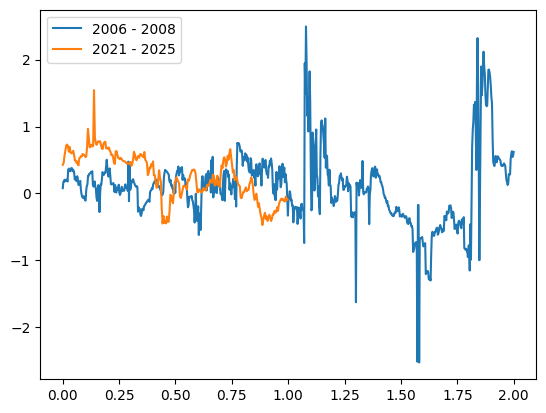

 Ratio


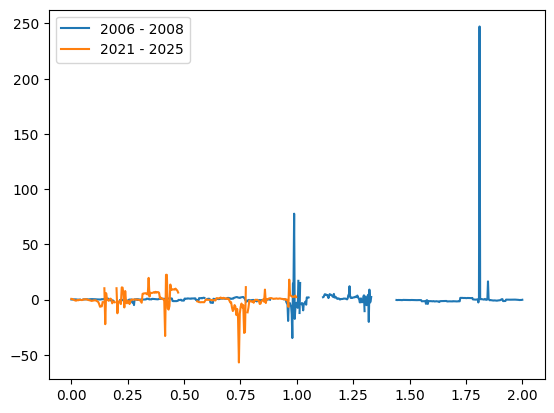

 Composite


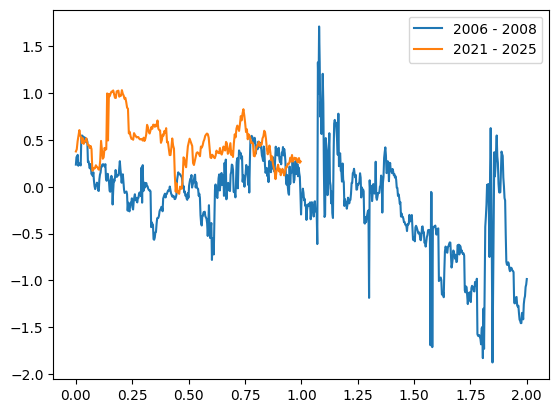

In [30]:
col_type = [
    ' Divergence',
    ' Ratio',
    ' Composite'
]

for col in col_type:
    combined_df = calc_economic_health(combined_df, col_type=col)
    print(f'{col}')
    plot_time_frames(year_start1=2006, year_end1=2008, year_start2=2021, year_end2=2025, df=combined_df, x1=f'health overall{col}')

## Analysis Part 2: Feature Engineering

### All Market DataFrame Columns:

#### S&P Data
- S&P Close
- S&P Open
- S&P Low
- S&P High
- S&P Vol

#### Dow Jones Data
- Dow Jones Close
- Dow Jones Open
- Dow Jones Low
- Dow Jones High
- Dow Jones Vol

#### NASDAQ Data
- NASDAQ Close
- NASDAQ Open
- NASDAQ Low
- NASDAQ High
- NASDAQ Vol

#### Monetary Policy & Financial Conditions

- **Interest Rates**
    - the baseline interest rate that influences all other borrowing costs
- **M2**
    - Money supply measure - tracks how much money is circulating in the economy
- **10Y-2Y Spread (10Y 2Y)**
    - Difference between 10-year and 2-year Treasury yields - *a key recession predictor*

#### Labor Market Health

- **Unemployment Rate (Unemploy Rates)**
    - Overall joblessness measure
- **Initial Claims**
    - New unemployment claims *an early warning signal*
- **Job Openings**:
    - *Construction* **(Job Openings Const)**
      Building sector hiring
    - *Private Sector* **(Job Openings Priv)**
      Overall business hiring

#### Consumer Financial Health

- **Personal Savings Rate (Personal Savings)**
    - How much income people save
- **Consumer Debt**
    - Credit card and revolving debt levels
- **Total Debt Service Payments (TDSP)**
    - Portion of income going to debt payments

#### Production & Business Activity

- **Industrial Production (Industrial Prod)**
    - Manufacturing output
- **Capacity Utilization (Capacity Prod)**
    - How much of industrial capacity is being used
- **Retail Sales (Retail Prod)**
    - Consumer spending at stores

#### Housing Market

- **30-Year Mortgage Rate (Mortgage 30 Years)**
    - Cost of home loans
- **New Housing Starts (New Private Housing)**
    - New home construction activity
- **House Price Index**
    - Home value trends

#### Inflation Metrics

- **Consumer Price Index (CPI)**
    - Overall price changes
- **Personal Consumption Expenditures (PCE)**
    - Alternative inflation measure

***'normalized_data' has all normalized data by add 'Score' after each feature name***

### Analysis

In [31]:
fe_df = pd.DataFrame()
fe_df['Date'] = all_markets['Date']
normalized_data = normalized_df.copy()

In [32]:
fe_df['Housing Stress'] = (
                            (
                                normalized_df['House Price Index'] / 
                                normalized_df['Personal Income']
                            )
                           * normalized_df['Mortgage 30 Years']
                          ) \
                            + normalized_df['TDSP']

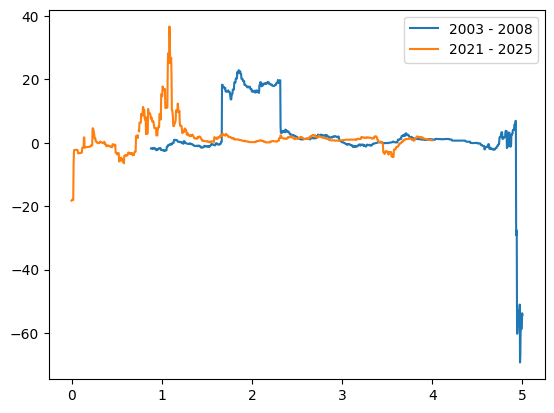

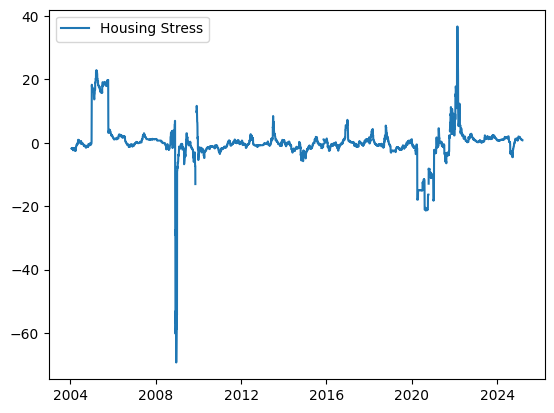

In [33]:
plot_time_frames(2003, 2008, 2021, 2025, fe_df, 'Housing Stress')
plot_time_frame(2000, 2025, fe_df, 'Housing Stress')

In [34]:
fe_df['Financial Stress'] = (normalized_data['Consumer Debt'] / normalized_data['M2']) * (normalized_data['10Y 2Y'])

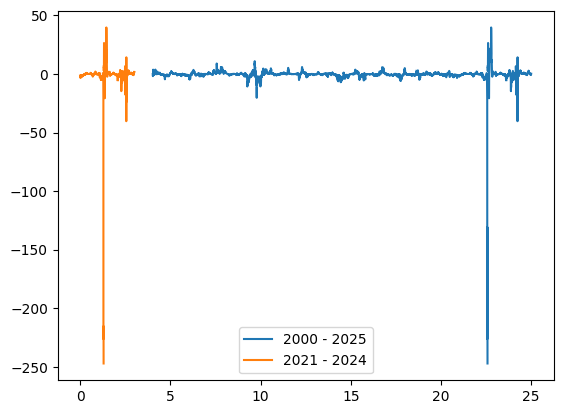

In [35]:
plot_time_frames(2000, 2025, 2021, 2024, fe_df, 'Financial Stress')

In [36]:
DAY_PREV = 30
fe_df['Economic Stress 30D'] = (normalized_data['Interest Rates'] * rate_of_change(normalized_data, 'CPI', DAY_PREV)) + \
                           (rate_of_change(normalized_data, 'Unemploy Rates', DAY_PREV) * rate_of_change(normalized_data, 'Initial Claims', DAY_PREV)) - \
                           rate_of_change(normalized_data, 'Industrial Prod', DAY_PREV) 
fe_df['Market Pressure 30D'] = (rate_of_change(normalized_data, 'S&P Close', DAY_PREV) * rate_of_change(normalized_data, 'S&P Vol', DAY_PREV)) / normalized_data['S&P Vol'].mean()
fe_df['Financial_Health 30D'] = rate_of_change(normalized_data, '10Y 2Y', DAY_PREV) + rate_of_change(normalized_data, 'Consumer Debt', DAY_PREV) - rate_of_change(normalized_data, 'Personal Savings', DAY_PREV)

In [37]:
DAY_PREV = 90
fe_df['Economic Stress 90D'] = (normalized_data['Interest Rates'] * rate_of_change(normalized_data, 'CPI', DAY_PREV)) + \
                           (rate_of_change(normalized_data, 'Unemploy Rates', DAY_PREV) * rate_of_change(normalized_data, 'Initial Claims', DAY_PREV)) - \
                           rate_of_change(normalized_data, 'Industrial Prod', DAY_PREV) 
fe_df['Market Pressure 90D'] = (rate_of_change(normalized_data, 'S&P Close', DAY_PREV) * rate_of_change(normalized_data, 'S&P Vol', DAY_PREV)) / normalized_data['S&P Vol'].mean()
fe_df['Financial_Health 90D'] = rate_of_change(normalized_data, '10Y 2Y', DAY_PREV) + rate_of_change(normalized_data, 'Consumer Debt', DAY_PREV) - rate_of_change(normalized_data, 'Personal Savings', DAY_PREV)

In [38]:
DAY_PREV = 150
fe_df['Economic Stress 150D'] = (normalized_data['Interest Rates'] * rate_of_change(normalized_data, 'CPI', DAY_PREV)) + \
                           (rate_of_change(normalized_data, 'Unemploy Rates', DAY_PREV) * rate_of_change(normalized_data, 'Initial Claims', DAY_PREV)) - \
                           rate_of_change(normalized_data, 'Industrial Prod', DAY_PREV) 
fe_df['Market Pressure 150D'] = (rate_of_change(normalized_data, 'S&P Close', DAY_PREV) * rate_of_change(normalized_data, 'S&P Vol', DAY_PREV)) / normalized_data['S&P Vol'].mean()
fe_df['Financial_Health 150D'] = rate_of_change(normalized_data, '10Y 2Y', DAY_PREV) + rate_of_change(normalized_data, 'Consumer Debt', DAY_PREV) - rate_of_change(normalized_data, 'Personal Savings', DAY_PREV)

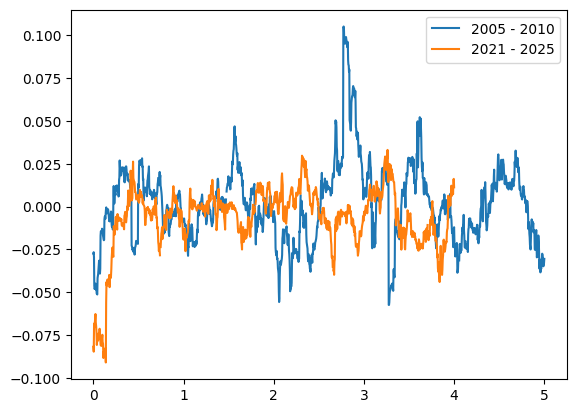

In [39]:
plot_time_frames(2005,2010, 2021, 2025, fe_df, 'Financial_Health 150D')

In [40]:
fe_df['Crash Risk'] = (

    # Market Pressure 40%
    0.2 * fe_df['Market Pressure 150D'] + 
    0.15 * fe_df['Market Pressure 90D'] +
    0.05 * fe_df['Market Pressure 30D'] +

    # Economic Stress 35%
    0.15 * fe_df['Economic Stress 150D'] + 
    0.12 * fe_df['Economic Stress 90D'] +
    0.08 * fe_df['Economic Stress 30D'] +

    # Financial Health 25%
    0.10 * fe_df['Financial_Health 150D'] +
    0.08 * fe_df['Financial_Health 90D'] +
    0.07 * fe_df['Financial_Health 30D']
)

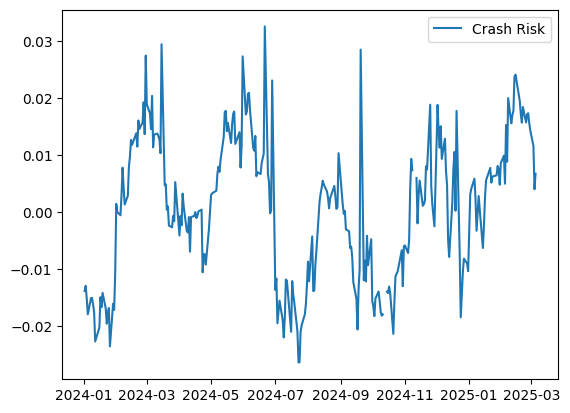

In [45]:
plot_time_frame(2024, 2025, fe_df, 'Crash Risk')

In [42]:
# insert

In [43]:
# Hello